Dataset '../data/car_prices.csv' loaded successfully. Sampled down to 50000 rows.

Data Split Complete.

--- Training Random Forest Model ---
Training Complete.

--- Random Forest Performance (R2 will reflect sampled data) ---
R-squared Score (R2): 0.9727


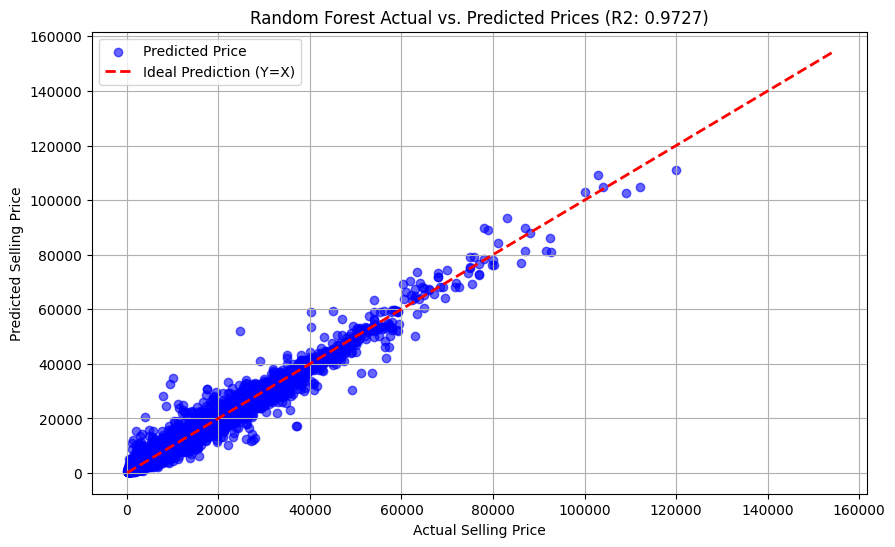


--- Training Deep Learning Model (Keras MLP) ---
Training Complete.
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step

--- Deep Learning Performance ---
DL R-squared Score (R2): 0.9680


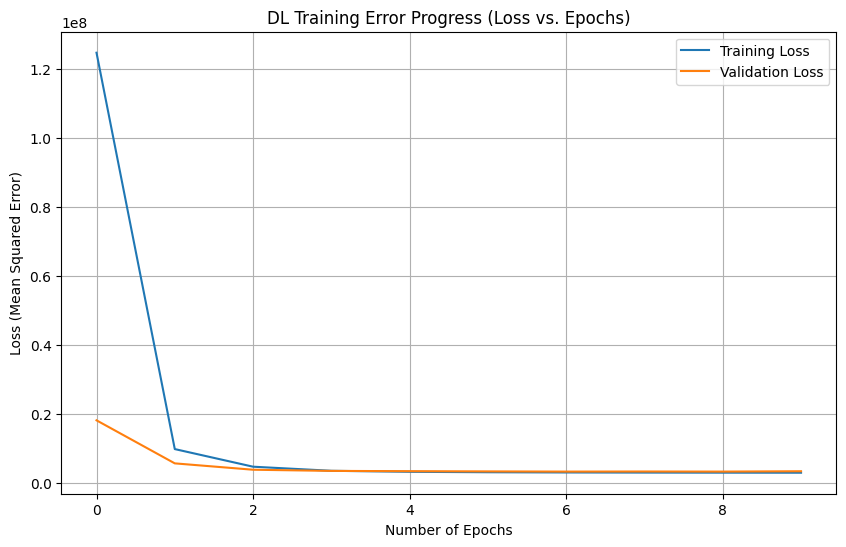


--- Time Series Analysis: Market Trend Visualization (Final Fix) ---


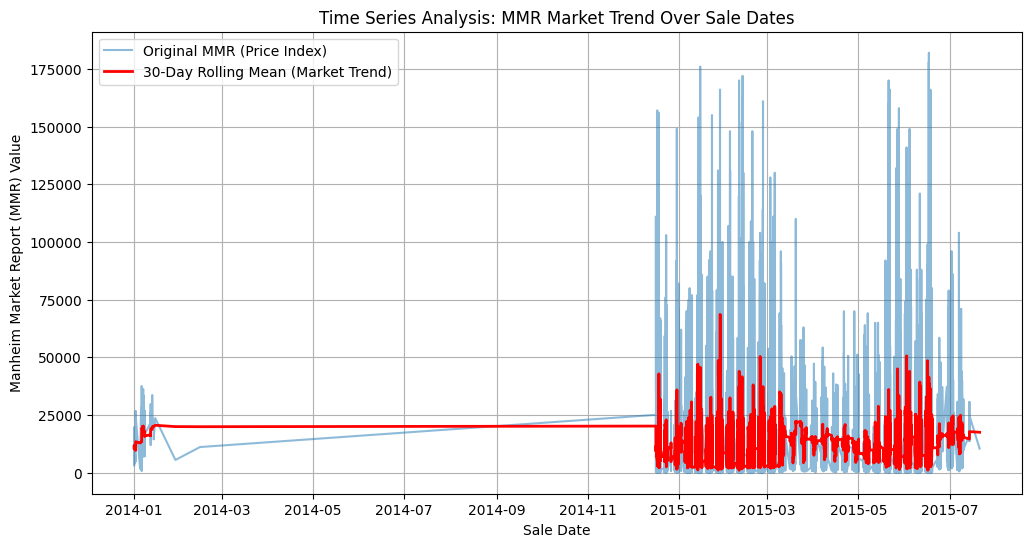



>>> INSTANT VEHICLE VALUATION AGENT (Softbot) <<<
Note: Provide values to match the feature columns: make, model, body, year, odometer, condition, mmr.

--- Agent Response ---
Predicted Optimal Selling Price for the 2011 Toyota Corolla:
💰  $2,400.55


In [21]:
# =====================================================================
# AI SOLUTION: PREDICTIVE VEHICLE PRICING TOOL (Integrated Script)
# FIX APPLIED: Switched Time Series Analysis to use a fixed INTEGER window (30)
# =====================================================================

# --- 1. Import Necessary Python Packages ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# --- 2. Data Loading and Setup (WITH SAMPLING) ---
file_path = '../data/car_prices.csv' 
SAMPLE_SIZE = 50000 
MIN_SAMPLES = 1000 

try:
    df_full = pd.read_csv(file_path)
    
    # *** FIX: Reduce data size using random sampling ***
    if df_full.shape[0] > SAMPLE_SIZE:
        df = df_full.sample(n=SAMPLE_SIZE, random_state=42)
        print(f"Dataset '{file_path}' loaded successfully. Sampled down to {df.shape[0]} rows.")
    else:
        df = df_full
        print(f"Dataset '{file_path}' loaded successfully. Shape: {df.shape}")
        
    if df.shape[0] < MIN_SAMPLES:
         print(f"Warning: Dataset size {df.shape[0]} is too small for proper ML/DL training.")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Using dummy data for demonstration.")
    data = {
        'year': [2015, 2017, 2016, 2018, 2014, 2019, 2015, 2017],
        'make': ['Kia', 'Ford', 'Honda', 'Toyota', 'Ford', 'Honda', 'Toyota', 'Kia'],
        'model': ['Sorento', 'Fusion', 'Civic', 'Corolla', 'Fiesta', 'CRV', 'Sienna', 'Optima'],
        'body': ['SUV', 'Sedan', 'Sedan', 'Sedan', 'Hatchback', 'SUV', 'Minivan', 'Sedan'],
        'condition': [4.5, 3.9, 5.0, 4.2, 3.5, 4.9, 4.0, 4.7],
        'odometer': [15000, 45000, 10000, 30000, 60000, 5000, 25000, 20000],
        'mmr': [20000, 15000, 18000, 21000, 10000, 24000, 28000, 17000],
        'sellingprice': [21000, 16000, 19000, 22000, 11000, 25000, 30000, 18000],
        'saledate': ['01/10/2024', '15/10/2024', '01/11/2024', '15/11/2024', '01/12/2024', '15/12/2024', '01/01/2025', '15/01/2025']
    }
    df = pd.DataFrame(data)

# --- 3. Data Cleaning and Preparation (for ML/DL Models) ---
features_to_use = ['year', 'make', 'model', 'body', 'condition', 'odometer', 'mmr']
df_ml = df[features_to_use + ['sellingprice']].copy()
df_ml.fillna(df_ml['mmr'].mean(numeric_only=True), inplace=True) 

categorical_features = ['make', 'model', 'body'] 

for col in categorical_features:
    df_ml[col].fillna('Missing', inplace=True)
    df_ml[col] = df_ml[col].astype(str)

X = df_ml.drop('sellingprice', axis=1)
Y = df_ml['sellingprice']

numerical_features = ['year', 'condition', 'odometer', 'mmr']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scaling/Mean Removal
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Label Encoding
    ],
    remainder='drop' 
)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
print("\nData Split Complete.")


# =====================================================================
# PART A: CLASSICAL ML (RANDOM FOREST REGRESSOR)
# =====================================================================

rf_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=5, random_state=42, max_depth=10, min_samples_split=5))
])

print("\n--- Training Random Forest Model ---")
rf_regressor.fit(X_train, Y_train) 
print("Training Complete.")

Y_rf_pred = rf_regressor.predict(X_test)
rf_r2 = r2_score(Y_test, Y_rf_pred)

print("\n--- Random Forest Performance (R2 will reflect sampled data) ---")
print(f"R-squared Score (R2): {rf_r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_rf_pred, alpha=0.6, color='blue', label='Predicted Price')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2, label='Ideal Prediction (Y=X)')
plt.title(f"Random Forest Actual vs. Predicted Prices (R2: {rf_r2:.4f})")
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.legend()
plt.grid(True)
plt.show()


# =====================================================================
# PART B: DEEP LEARNING (DL) - MLP Regressor
# =====================================================================

X_train_processed = preprocessor.fit_transform(X_train).toarray() 
X_test_processed = preprocessor.transform(X_test).toarray()
input_dimension = X_train_processed.shape[1]

Y_train_array = Y_train.values
Y_test_array = Y_test.values

def build_dl_model(input_dim):
    """Builds a Multi-Layer Perceptron (MLP) for Regression using Keras."""
    model = Sequential([
        Dense(128, input_shape=(input_dim,), activation='relu'), 
        Dense(64, activation='relu'),
        Dense(1) 
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae']) 
    return model

dl_model = build_dl_model(input_dimension)
print("\n--- Training Deep Learning Model (Keras MLP) ---")
dl_history = dl_model.fit(
    X_train_processed, Y_train_array,
    epochs=10,             
    batch_size=32,         
    validation_split=0.1, 
    verbose=0
)
print("Training Complete.")

Y_dl_pred = dl_model.predict(X_test_processed).flatten()
dl_r2 = r2_score(Y_test_array, Y_dl_pred)

print("\n--- Deep Learning Performance ---")
print(f"DL R-squared Score (R2): {dl_r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(dl_history.history['loss'], label='Training Loss')
plt.plot(dl_history.history['val_loss'], label='Validation Loss')
plt.title('DL Training Error Progress (Loss vs. Epochs)')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()


# =====================================================================
# PART C: TIME SERIES ANALYSIS (TSA) - Market Trend Visualization
# =====================================================================

print("\n--- Time Series Analysis: Market Trend Visualization (Final Fix) ---")
# Using 30 as an INTEGER window to bypass Pandas datetime index validation errors.
WINDOW_SIZE = 30 

# 1. Setup Data for TSA
df_tsa = df_full[['saledate', 'mmr']].copy()

# 2. Clean and prepare the data
df_tsa.dropna(subset=['saledate', 'mmr'], inplace=True)
df_tsa['saledate'] = pd.to_datetime(df_tsa['saledate'], errors='coerce') 
df_tsa.dropna(subset=['saledate'], inplace=True) 
df_tsa.sort_values('saledate', inplace=True)

# 3. Apply Integer Rolling Mean
# This is the final fix: Perform integer rolling on the numerical data after sorting by date.
df_tsa['rolling_mean_mmr'] = df_tsa['mmr'].rolling(window=WINDOW_SIZE).mean()

# 4. Plot the result
df_plot = df_tsa.dropna(subset=['rolling_mean_mmr'])

plt.figure(figsize=(12, 6))
plt.plot(df_plot['saledate'], df_plot['mmr'], label='Original MMR (Price Index)', alpha=0.5)
plt.plot(df_plot['saledate'], df_plot['rolling_mean_mmr'], label=f'{WINDOW_SIZE}-Day Rolling Mean (Market Trend)', color='red', linewidth=2)
plt.title('Time Series Analysis: MMR Market Trend Over Sale Dates')
plt.xlabel('Sale Date')
plt.ylabel('Manheim Market Report (MMR) Value')
plt.legend()
plt.grid(True)
plt.show()


# =====================================================================
# PART D: CHATBOT / SOFTBOT FEATURE (Interactive Agent)
# =====================================================================

def launch_valuation_softbot(model, X_train_cols):
    """
    Simulates an interactive command-line softbot (Instant Valuation Agent).
    """
    print("\n\n=======================================================")
    print(">>> INSTANT VEHICLE VALUATION AGENT (Softbot) <<<")
    print("=======================================================")

    user_inputs = {}

    print("Note: Provide values to match the feature columns: make, model, body, year, odometer, condition, mmr.")
    user_inputs['make'] = input("Enter Vehicle Make (e.g., Toyota): ").strip()
    user_inputs['model'] = input("Enter Vehicle Model (e.g., Corolla): ").strip()
    user_inputs['body'] = input("Enter Body Type (e.g., Sedan, SUV): ").strip()

    try:
        user_inputs['year'] = int(input("Enter Year (e.g., 2019): ").strip())
        user_inputs['odometer'] = int(input("Enter Odometer Reading (e.g., 25000): ").strip())
        user_inputs['condition'] = float(input("Enter Condition Rating (1.0 - 5.0): ").strip())
        user_inputs['mmr'] = float(input("Enter Current MMR Value (Market Price Index): ").strip())
    except ValueError:
        print("Invalid input for a numerical field. Agent shutting down.")
        return

    try:
        new_data_point = pd.DataFrame([user_inputs])
        new_data_point = new_data_point.reindex(columns=X_train_cols, fill_value=np.nan)
        
        # Call the trained ML model
        predicted_price = model.predict(new_data_point)
        
        print("\n--- Agent Response ---")
        print(f"Predicted Optimal Selling Price for the {user_inputs['year']} {user_inputs['make']} {user_inputs['model']}:")
        print(f"💰  ${predicted_price[0]:,.2f}")

    except Exception as e:
        print(f"\nAgent encountered a prediction error: {e}")

# Call the Softbot function using the trained Random Forest model
launch_valuation_softbot(rf_regressor, X_train.columns)